In [1]:
# Скрипт для демонстрации загрузки геоданных из OSM и работы с ними

In [2]:
from shapely.geometry import Polygon,LineString

from shapely.ops import linemerge, unary_union, polygonize

import datetime
import numpy as np
import pysal
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import shape
from shapely.geometry import Point
import requests
import random
import overpy
import contextily as ctx
import h3

import pandas as pd

<b> Задача </b> : посчитать число магазинов в округах Города и визуализировать плотность на карте

#### Загрузка границ округов

In [3]:
overpass_query = \
"""[out:json]
;
area["name:en"="Berlin"];
(
  relation
    ["boundary"="administrative"]
    ["admin_level"="9"]
    (area);
);
(
  ._;
  >;
);
out geom;
 """

#### Использование библиотеки overpy

In [4]:
api = overpy.Overpass()

city_borders = api.query(overpass_query)


In [5]:
lss = []
for ii_w,way in enumerate(city_borders.ways):
    """ цикл по ребрам для записи координат вершин"""
    ls_coords = []

    for node in way.nodes:
        ls_coords.append((node.lon,node.lat)) # 

    lss.append(LineString(ls_coords)) # сохраняем координаты в линию  -linestring


merged = linemerge([*lss]) # соединяем все линии
borders = unary_union(merged) # linestrings в MultiLineString
polygons = list(polygonize(borders))

In [6]:
gdf_zones_overpass= pd.Series(polygons, index=range(len(polygons))).to_frame()
gdf_zones_overpass.columns=['geometry']

In [7]:
gdf_zones_overpass =gpd.GeoDataFrame(gdf_zones_overpass, crs='epsg:4326', geometry='geometry')

<AxesSubplot:>

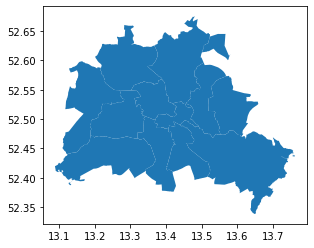

In [8]:
gdf_zones_overpass.plot()

#### Использование библиотеки requests

In [9]:
overpass_url = "http://overpass-api.de/api/interpreter"
response = requests.get(overpass_url, params={'data': overpass_query})
response.json()

{'version': 0.6,
 'generator': 'Overpass API 0.7.58.5 b0c4acbb',
 'osm3s': {'timestamp_osm_base': '2022-07-22T19:54:02Z',
  'timestamp_areas_base': '2022-07-20T10:48:09Z',
  'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'},
 'elements': [{'type': 'node',
   'id': 21509149,
   'lat': 52.442978,
   'lon': 13.7569427},
  {'type': 'node', 'id': 26753043, 'lat': 52.5404013, 'lon': 13.4041908},
  {'type': 'node', 'id': 26753083, 'lat': 52.5323485, 'lon': 13.4064243},
  {'type': 'node', 'id': 26753581, 'lat': 52.5361014, 'lon': 13.4067482},
  {'type': 'node', 'id': 27199831, 'lat': 52.5675428, 'lon': 13.3844451},
  {'type': 'node', 'id': 27199834, 'lat': 52.5664477, 'lon': 13.3814821},
  {'type': 'node', 'id': 29215037, 'lat': 52.5082102, 'lon': 13.4052837},
  {'type': 'node', 'id': 29276220, 'lat': 52.5073345, 'lon': 13.4283665},
  {'type': 'node',
   'id': 29336704,
   'lat': 52.515747,
   'lon': 13.3096834,
   'tags': 

In [10]:
set([i['type'] for i in response.json()['elements']])

{'node', 'relation', 'way'}

In [11]:
dict_response = response.json()

In [12]:
dict_response['elements'][2319]

{'type': 'node', 'id': 452405652, 'lat': 52.5234851, 'lon': 13.4681035}

In [13]:
for way in dict_response['elements']:
    
    if way['type']=='way':
        line = LineString([(node['lon'],node['lat']) for node in way['geometry']]) # 
        lss.append(line) # сохраняем координаты в линию  -linestring


merged = linemerge([*lss]) # соединяем все линии
borders = unary_union(merged)#объединяет linestrings в multistring

polygons = list(polygonize(borders))

In [14]:
gdf_zones_url= pd.Series(polygons, index=range(len(polygons))).to_frame()
gdf_zones_url.columns=['geometry']

In [15]:
gdf_zones_url =gpd.GeoDataFrame(gdf_zones_url, crs='epsg:4326', geometry='geometry')

<AxesSubplot:>

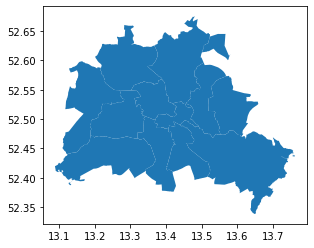

In [16]:
gdf_zones_url.plot()

#### Загрузка файла geojson из overpass turbo c помощью библиотеки geopandas

In [17]:
# ссылка на overpass turbo - https://overpass-turbo.eu/
#
# Скрипт на выгрузку: 
"""
[out:json];
 area["name:en"="Berlin"];
 (
     rel["boundary"="administrative"]["admin_level"="9"](area);
 );
/*added by auto repair*/
 (._;>;);
/*end of auto repair*/
out;
"""

'\n[out:json];\n area["name:en"="Berlin"];\n (\n     rel["boundary"="administrative"]["admin_level"="9"](area);\n );\n/*added by auto repair*/\n (._;>;);\n/*end of auto repair*/\nout;\n'

In [18]:
df_city_borders = gpd.read_file('berlin_borders.geojson')

In [19]:
df_city_borders.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,access,addr:city,addr:country,addr:housename,addr:housenumber,...,toilets,traffic_sign,type,waterway,website,wheelchair,wikidata,wikipedia,@relations,geometry
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571..."
1,relation/16343,relation/16343,None,None,None,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-spandau/,None,Q158083,de:Bezirk Spandau,None,"POLYGON ((13.15724 52.50162, 13.15722 52.50162..."
2,relation/16347,relation/16347,Area,9.00,4885,None,None,None,None,None,...,None,None,boundary,None,None,None,Q163966,de:Bezirk Mitte,None,"POLYGON ((13.39929 52.54894, 13.39929 52.54895..."
3,relation/55734,relation/55734,Area,9.00,32815,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-steglitz-zehlendorf/,None,Q158064,de:Bezirk Steglitz-Zehlendorf,None,"POLYGON ((13.34570 52.41524, 13.34603 52.41553..."
4,relation/55754,relation/55754,Area,9.00,32817,None,None,None,None,None,...,None,None,boundary,None,http://www.berlin.de/ba-treptow-koepenick/,None,Q158089,de:Bezirk Treptow-Köpenick,None,"POLYGON ((13.71002 52.39628, 13.71018 52.39619..."


In [20]:
type(df_city_borders)

geopandas.geodataframe.GeoDataFrame

In [21]:
df_city_borders.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

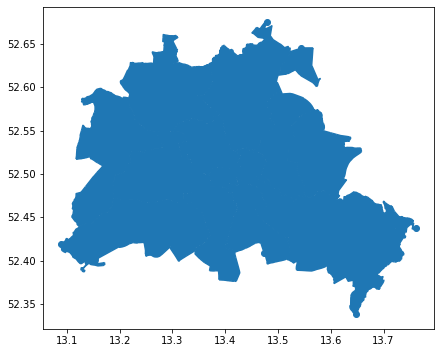

In [22]:
df_city_borders.plot(figsize=(7,10))

In [23]:
df_city_borders.geometry

0      POLYGON ((13.21740 52.58748, 13.21644 52.58571...
1      POLYGON ((13.15724 52.50162, 13.15722 52.50162...
2      POLYGON ((13.39929 52.54894, 13.39929 52.54895...
3      POLYGON ((13.34570 52.41524, 13.34603 52.41553...
4      POLYGON ((13.71002 52.39628, 13.71018 52.39619...
                             ...                        
539                            POINT (13.40224 52.56900)
540                            POINT (13.33674 52.50572)
541                            POINT (13.32002 52.46785)
542                            POINT (13.33525 52.50594)
543                            POINT (13.33492 52.50610)
Name: geometry, Length: 544, dtype: geometry

#### Вычисляем площадь округов

In [24]:
df_city_borders.area

/var/folders/b7/qjb6gwz957n_8d871l0pzdm00000gn/T/ipykernel_64066/3183481316.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_city_borders.area


0      0.011848
1      0.012165
2      0.005216
3      0.013554
4      0.022160
         ...   
539    0.000000
540    0.000000
541    0.000000
542    0.000000
543    0.000000
Length: 544, dtype: float64

In [25]:
df_city_borders_mercator  = df_city_borders.to_crs('epsg:32637')# меняем проекцию для корректного расчета расстояний

In [26]:
df_city_borders_mercator.geometry

0      POLYGON ((-1229442.249 6144792.152, -1229578.0...
1      POLYGON ((-1236942.740 6137062.977, -1236944.0...
2      POLYGON ((-1219089.333 6136078.524, -1219089.2...
3      POLYGON ((-1228098.712 6123012.068, -1228065.4...
4      POLYGON ((-1204841.000 6111895.102, -1204833.9...
                             ...                        
539                     POINT (-1218073.102 6138167.274)
540                     POINT (-1224973.935 6132987.041)
541                     POINT (-1227629.994 6129325.651)
542                     POINT (-1225062.658 6133048.739)
543                     POINT (-1225077.739 6133073.397)
Name: geometry, Length: 544, dtype: geometry

In [27]:
df_city_borders['area']=df_city_borders_mercator.area

In [28]:
df_city_borders['area'].value_counts() # в геометрии есть точки, вершины границ округов, которые нужно убрать

0.000000e+00    530
9.594098e+07      1
9.874715e+07      1
4.229119e+07      1
1.102452e+08      1
1.799081e+08      1
2.186602e+07      1
5.698875e+07      1
4.825462e+07      1
6.630983e+07      1
1.107600e+08      1
6.948740e+07      1
5.593635e+07      1
1.381917e+07      1
1.723417e+03      1
Name: area, dtype: int64

In [29]:
df_city_borders = df_city_borders[df_city_borders['area']>0]

<AxesSubplot:>

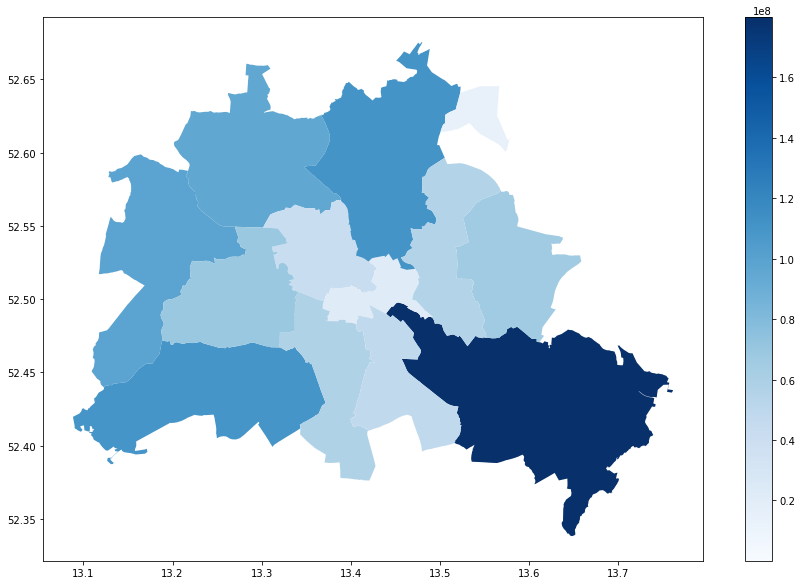

In [57]:
df_city_borders.plot(figsize=(15,10),column='area', cmap='Blues' ,legend=True)# визуализируем, раскрашивая по размеру площади

#### Загружаем супермаркеты

In [31]:
query_sups="""area["name:en"="Berlin"];
        (
            node['shop'='supermarket'](area);
        );
        out;
        """
result1 = api.query(query_sups)

In [32]:
gdf_stores = gpd.GeoDataFrame([ Point(x.lon, x.lat) for x in result1.nodes])
gdf_stores.columns=['geometry']

In [33]:
gdf_stores.head()

,geometry
0,POINT (13.40737 52.50982)
1,POINT (13.31248 52.57168)
2,POINT (13.31693 52.56640)
3,POINT (13.32114 52.57049)
4,POINT (13.32288 52.49140)


Задаем систему координат

In [34]:
gdf_stores.crs

In [35]:
gdf_stores = gdf_stores.set_crs('epsg:4326')

In [36]:
gdf_stores.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Сцепляем округа и магазины

In [37]:
gdf_city_regions_shops = gpd.sjoin(df_city_borders, gdf_stores, predicate='contains', how='left')

In [38]:
gdf_city_regions_shops.head()

,id,@id,TMC:cid_58:tabcd_1:Class,TMC:cid_58:tabcd_1:LCLversion,TMC:cid_58:tabcd_1:LocationCode,access,addr:city,addr:country,addr:housename,addr:housenumber,...,type,waterway,website,wheelchair,wikidata,wikipedia,@relations,geometry,area,index_right
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",9.594098e+07,56.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",9.594098e+07,158.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",9.594098e+07,328.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",9.594098e+07,10.0
0,relation/16334,relation/16334,Area,9.00,4942,None,None,None,None,None,...,boundary,None,http://www.berlin.de/ba-reinickendorf/,None,Q158876,de:Bezirk Reinickendorf,None,"POLYGON ((13.21740 52.58748, 13.21644 52.58571...",9.594098e+07,596.0


In [39]:
gdf_city_regions = gdf_city_regions_shops[['name','area','id','geometry']].dissolve(by=['name','area'], aggfunc='count') # группируем по зонам для расчета числа магазинов

In [40]:
gdf_city_regions.head()

,,geometry,id
name,area,,
Charlottenburg-Wilmersdorf,6.948740e+07,"POLYGON ((13.33533 52.51504, 13.33538 52.51486...",118
Friedrichshain-Kreuzberg,2.186602e+07,"POLYGON ((13.47414 52.51894, 13.47547 52.51691...",89
Lichtenberg,5.593635e+07,"POLYGON ((13.46810 52.52349, 13.46760 52.52366...",46
Marzahn-Hellersdorf,6.630983e+07,"POLYGON ((13.54232 52.56615, 13.54240 52.56616...",30
Mitte,4.229119e+07,"POLYGON ((13.39935 52.54656, 13.39936 52.54654...",122


In [41]:
gdf_city_regions.reset_index(inplace=True)

In [58]:
# плотность на 1 кв км
gdf_city_regions['density']=gdf_city_regions['id']/gdf_city_regions['area']/(10**(-6))

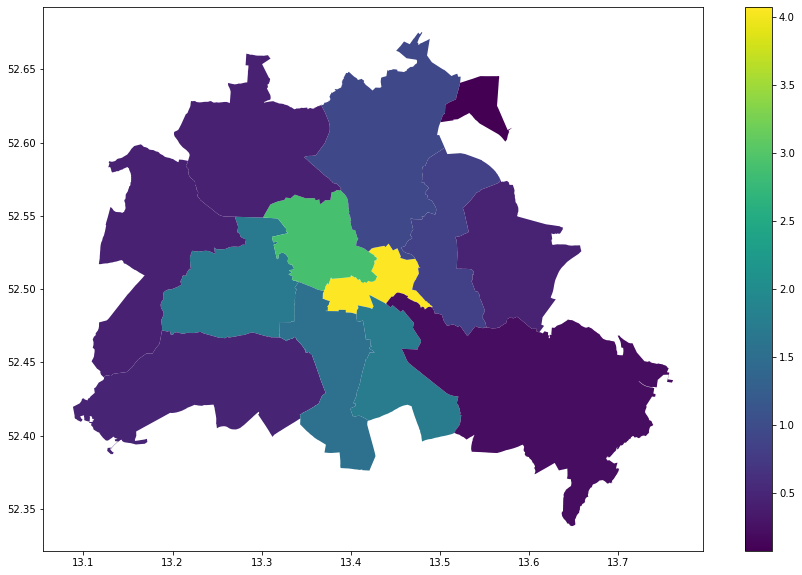

In [59]:
gdf_city_regions.plot(column='density', figsize=(15,10),legend=True);

In [44]:
gdf_city_regions.to_file('gdf_city_regions.geojson', driver='GeoJSON')

/Users/yurivlasov/Projects/miniforge3/envs/all_geodata_scripts/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
